# Data exploration and data wrangling

For all the notebooks you will find here, we first load the same set of libraries, and we also load the tidy data into a variable called `res`.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 25, 
      'axes.titlesize': 25, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 20 

res = pd.read_csv('../data/master_table.tsv', sep='\t')
print('Number of genes included in analysis:', len(res))
print('DE genes that will be analyzed at 50 hrs: ', (res['padj-50'] < 0.05).sum())
print('DE genes that will be analyzed at 58 hrs: ', (res['padj-58'] < 0.05).sum())
print('DE genes in both conditions: ', res.query('`padj-50` < 0.05 & `padj-58` < 0.05').shape[0])

Number of genes included in analysis: 12244
DE genes that will be analyzed at 50 hrs:  1663
DE genes that will be analyzed at 58 hrs:  3622
DE genes in both conditions:  741


# Data Exploration and QC

Briefly, we performed RNA-seq of animals exposed to ascr#10 until they were pre-licensed adults or until they were licensed adults (recall the licensing event is egg-laying); this corresponds to animals aged 50hrs and 58hrs respectively. In a previously published article, we processed this data using Salmon + DESeq to identify differentially expressed genes. 

Number of genes that have the same log(FC) sign and are DE in at least one condition:
3087
Number of genes that have different log(FC) sign and are DE in at least one condition:
1457


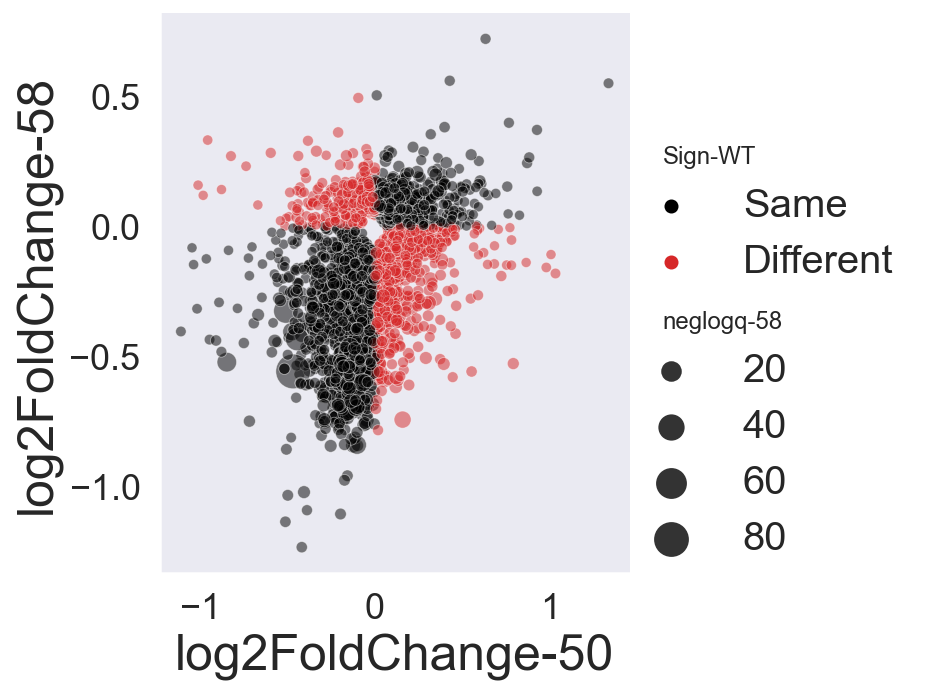

In [2]:
res = res[(res['padj-50'] < 0.05) | (res['padj-58'] < 0.05)]

def save(name, transparent=False):
    """Wrapper to abbreviate save file location."""
    plt.savefig('../figs/' + name, bbox_inches='tight', transparent=transparent)
    
sns.relplot(
    data=res,
    x="log2FoldChange-50", y="log2FoldChange-58",
    size='neglogq-58',
    kind="scatter", sizes=(25, 300), hue='Sign-WT',
    palette=['black', 'tab:red'], hue_order=['Same', 'Different'],
    alpha=0.5
)

print('Number of genes that have the same log(FC) sign and are DE in at least one condition:')
print(res.query('`Sign-WT` == "Same" & (`padj-58` < 0.05 | `padj-50` < 0.05)' ).shape[0])
print('Number of genes that have different log(FC) sign and are DE in at least one condition:')
print(res.query('`Sign-WT` != "Same" & (`padj-58` < 0.05 | `padj-50` < 0.05)' ).shape[0])

Perhaps a more productive view of the data comes from looking at the genes that are commony differentially expressed in response to ascr#10 exposure at both timepoints:

Number of genes that have the same log(FC) sign and are DE in at least one condition:
650
Number of genes that have different log(FC) sign and are DE in at least one condition:
91


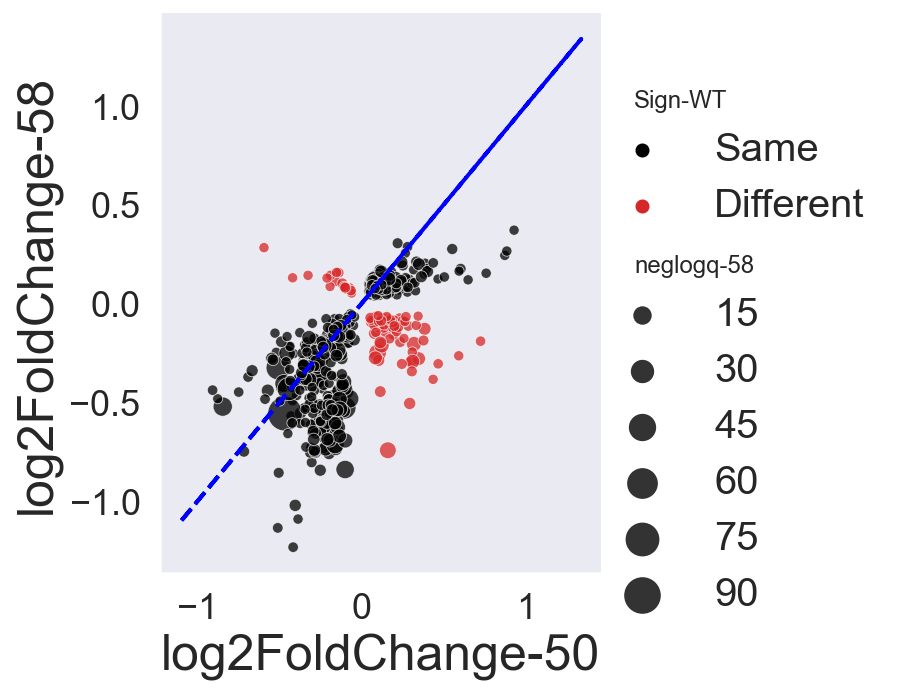

In [3]:
sns.relplot(
    data=res[(res['padj-58'] < 0.05) & (res['padj-50'] < 0.05)],
    x="log2FoldChange-50", y="log2FoldChange-58",
    size='neglogq-58',
    kind="scatter", sizes=(25, 300), hue='Sign-WT',
    palette=['black', 'tab:red'], hue_order=['Same', 'Different'],
    alpha=0.75,
)

plt.plot(res['log2FoldChange-50'], 1 * res['log2FoldChange-50'],
         label='50hrs = 58hrs', color='blue', ls='--')

print('Number of genes that have the same log(FC) sign and are DE in at least one condition:')
print(res.query('`Sign-WT` == "Same" & (`padj-58` < 0.05 & `padj-50` < 0.05)' ).shape[0])
print('Number of genes that have different log(FC) sign and are DE in at least one condition:')
print(res.query('`Sign-WT` != "Same" & (`padj-58` < 0.05 & `padj-50` < 0.05)' ).shape[0])

In the above graph, it becomes clear that, at least for commonly regulated genes, the majority of genes are positively correlated between both conditions. The blue line in the graph is the line $y=x$, suggesting that, on average, ascr#10 responsive genes do not change their response in a time-dependent manner. 

Moreover, not that the off-diagonal points are much, much fewer than before! This suggests that those off-diagonal genes are false measurements in at least one condition. A slightly more rigorous argument follows:

Consider those genes that are DE in at least one condition (the **Union**), and which are either correlated or anticorrelated. Assume that the incomplete overlap between both conditions is due to false positives and false negatives, and is NOT the result of additional layers of regulation (a major, but reasonable assumption). Then, it follows that genes DE in BOTH conditions (the **Intersection**) are genes whose measurements were more replicable on average, since they were detected in both conditions.

Then, it follows that the proportion of correlated : anti-correlated genes should be the same if we measure it in *either* the union or the intersection. In the **union**, this proportion is $1455 / 3084 \sim .5$, whereas in the **intersection**, the proportion is $91 / 650 =.14$. The fraction of anti-correlated genes has gone down significantly. _Therefore, under the assumption that the genetic regulation is identical at 50 AND at 58 hours, we conclude that the off-diagonal genes are anticorrelated due to noise, and we ignore any genes in the **intersection** that are anti-correlated_.